# Proyecto 5: SST para el bounding box de una ecoregion

Emilio Mayorga, https://github.com/emiliom/, 2023-3-2

https://github.com/Intercoonecta/proy5-regiones-comparacion

In [1]:
import datetime
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import rioxarray
import xarray as xr

In [2]:
datos_ruta = Path("~/shared/proyecto5")

In [3]:
ecoregiones_gdf = gpd.read_file(datos_ruta / "MEOW" / "meow_ecos.shp")

In [4]:
def seleccion_ecoregion(gdf, ecoregion):
    sel_gdf = gdf[gdf["ECOREGION"] == ecoregion]
    sel_bordes_df = sel_gdf.geometry.bounds
    sel_bordes = dict(
        minx=sel_bordes_df.minx.values[0],
        maxx=sel_bordes_df.maxx.values[0],
        miny=sel_bordes_df.miny.values[0],
        maxy=sel_bordes_df.maxy.values[0],
    )
    return sel_gdf, sel_bordes

In [5]:
def limpiarnombre(s):
    return s.replace("/", "-").replace(" ", "-")

## Lectura de datos de ERDDAP

Datos de SST (temperature de la superficie) mensuales. https://coastwatch.pfeg.noaa.gov/erddap/es/griddap/erdMH1sstdmdayR20190SQ.html. Primero accedemos al dataset, pero nada más a los metadatos. No descargamos datos hasta que realmente los necesitemos, ya cuando hemos definido un query reducido geográfica y temporalmente.

In [6]:
erddap_opendap_url = 'https://coastwatch.pfeg.noaa.gov/erddap/es/griddap/erdMH1sstdmdayR20190SQ'

fuente_ds = xr.open_dataset(erddap_opendap_url)

In [7]:
fuente_ds

<xarray.Dataset>
Dimensions:    (time: 226, latitude: 4320, longitude: 8640)
Coordinates:
  * time       (time) datetime64[ns] 2003-01-16 ... 2021-10-16
  * latitude   (latitude) float64 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    sstMasked  (time, latitude, longitude) float32 ...
Attributes: (12/36)
    acknowledgement:           NASA GSFC
    cdm_data_type:             Grid
    contact:                   https://www.pfeg.noaa.gov/guest_book.html
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creation_date:             2021-12-24 10:53:33.698319
    creator_email:             erd.data@noaa.gov
    ...                        ...
    summary:                   This is the delayed, science-quality, monthly ...
    testOutOfDate:             now-120days
    time_coverage_end:         2021-10-16T00:00:00Z
    time_coverage_start:       2003-01-16T00:00:00Z
    title:                     SST, AQUA_MODIS, L3m.MO.SST.sst.4km, Masked, S...
    Westernmost_Easting:       -179.9792

In [8]:
print(f"Tamaño del dataset: {fuente_ds.nbytes/1e6} MB")

Tamaño del dataset: 33741.724688 MB


## Definir la ecoregion e intervalo de años

- Southern California Bight
- Southern Caribbean
- Guayaquil
- Central Chile
- Malvinas/Falklands
- Patagonian Shelf

**Seleccionar abajo la ecoregión e intervalo de años deseados**

In [9]:
ecoregion_seleccion = "Patagonian Shelf"

año_inicio = 2004
año_final= 2008

ecoregion_seleccion_limpio = limpiarnombre(ecoregion_seleccion)

## Seleccionar la ecoregion

In [10]:
ecoregion_gdf, ecoregion_bordes = seleccion_ecoregion(ecoregiones_gdf, ecoregion_seleccion)

In [11]:
ecoregion_bordes

{'minx': -71.0765287327369,
 'maxx': -56.23101668242657,
 'miny': -54.76612349260381,
 'maxy': -41.204975442016234}

## Definir subset de la ecoregion del dataset de SST

**Atención!** El orden original de las dimensiones es importante! Si van de valores bajos a valore altos, o viceversa.

In [12]:
subset_ds = fuente_ds.sel(
    time=slice(datetime.datetime(año_inicio,1,1), datetime.datetime(año_final,12,31)), 
    latitude=slice(ecoregion_bordes['maxy'], ecoregion_bordes['miny']),
    longitude=slice(ecoregion_bordes['minx'], ecoregion_bordes['maxx'])
)

In [13]:
subset_ds

<xarray.Dataset>
Dimensions:    (time: 60, latitude: 325, longitude: 356)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-16 2004-02-15 ... 2008-12-16
  * latitude   (latitude) float64 -41.23 -41.27 -41.31 ... -54.65 -54.69 -54.73
  * longitude  (longitude) float64 -71.06 -71.02 -70.98 ... -56.35 -56.31 -56.27
Data variables:
    sstMasked  (time, latitude, longitude) float32 ...
Attributes: (12/36)
    acknowledgement:           NASA GSFC
    cdm_data_type:             Grid
    contact:                   https://www.pfeg.noaa.gov/guest_book.html
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creation_date:             2021-12-24 10:53:33.698319
    creator_email:             erd.data@noaa.gov
    ...                        ...
    summary:                   This is the delayed, science-quality, monthly ...
    testOutOfDate:             now-120days
    time_coverage_end:         2021-10-16T00:00:00Z
    time_coverage_start:       2003-01-16T00:00:00Z
    title:                     SST, AQUA_MODIS, L3m.MO.SST.sst.4km, Masked, S...
    Westernmost_Easting:       -179.9792

In [14]:
print(f"Tamaño del dataset: {subset_ds.nbytes/1e6} MB")

Tamaño del dataset: 27.773928 MB


Descargar los datos al dataset de xarray `subset_fuente_ds`

### Descargar los datos e inspeccionarlos

Aquí por fin descargamos los datos.

In [15]:
%%time
subset_ds.load();

CPU times: user 610 ms, sys: 530 ms, total: 1.14 s
Wall time: 4min 53s


In [16]:
subset_ds

<xarray.Dataset>
Dimensions:    (time: 60, latitude: 325, longitude: 356)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-16 2004-02-15 ... 2008-12-16
  * latitude   (latitude) float64 -41.23 -41.27 -41.31 ... -54.65 -54.69 -54.73
  * longitude  (longitude) float64 -71.06 -71.02 -70.98 ... -56.35 -56.31 -56.27
Data variables:
    sstMasked  (time, latitude, longitude) float32 nan nan nan ... 6.765 6.745
Attributes: (12/36)
    acknowledgement:           NASA GSFC
    cdm_data_type:             Grid
    contact:                   https://www.pfeg.noaa.gov/guest_book.html
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creation_date:             2021-12-24 10:53:33.698319
    creator_email:             erd.data@noaa.gov
    ...                        ...
    summary:                   This is the delayed, science-quality, monthly ...
    testOutOfDate:             now-120days
    time_coverage_end:         2021-10-16T00:00:00Z
    time_coverage_start:       2003-01-16T00:00:00Z
    title:                     SST, AQUA_MODIS, L3m.MO.SST.sst.4km, Masked, S...
    Westernmost_Easting:       -179.9792

Un primer vistazo

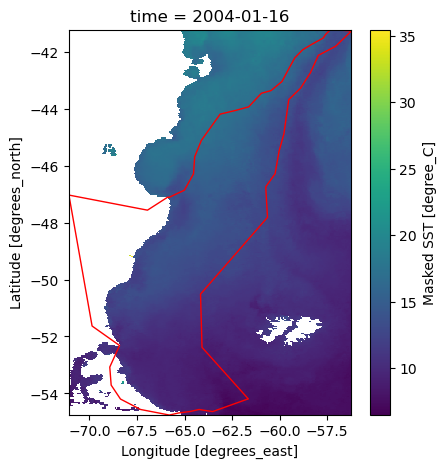

In [17]:
_, ax = plt.subplots(ncols=1, figsize=(5,5))
subset_ds.sstMasked.isel(time=0).plot(ax=ax)
ecoregion_gdf.plot(ax=ax, edgecolor='red', facecolor='none');

## Aplicar máscara basada en el polígono de la ecoregión

Usamos `rioxarray` para aplicar el polígono de la ecoregión como una máscara del área que vamos a retener.

In [18]:
subset_ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
subset_ds.rio.write_crs("epsg:4326", inplace=True)

ecoregion_mascara_ds = subset_ds.rio.clip(
    ecoregion_gdf.geometry.values, 
    ecoregion_gdf.crs, 
    invert=False,
    drop=False,
)

In [19]:
ecoregion_mascara_ds

<xarray.Dataset>
Dimensions:      (latitude: 325, longitude: 356, time: 60)
Coordinates:
  * latitude     (latitude) float64 -41.23 -41.27 -41.31 ... -54.69 -54.73
  * longitude    (longitude) float64 -71.06 -71.02 -70.98 ... -56.31 -56.27
  * time         (time) datetime64[ns] 2004-01-16 2004-02-15 ... 2008-12-16
    spatial_ref  int64 0
Data variables:
    sstMasked    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/36)
    acknowledgement:           NASA GSFC
    cdm_data_type:             Grid
    contact:                   https://www.pfeg.noaa.gov/guest_book.html
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creation_date:             2021-12-24 10:53:33.698319
    creator_email:             erd.data@noaa.gov
    ...                        ...
    summary:                   This is the delayed, science-quality, monthly ...
    testOutOfDate:             now-120days
    time_coverage_end:         2021-10-16T00:00:00Z
    time_coverage_start:       2003-01-16T00:00:00Z
    title:                     SST, AQUA_MODIS, L3m.MO.SST.sst.4km, Masked, S...
    Westernmost_Easting:       -179.9792

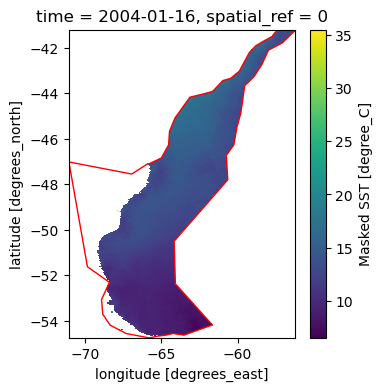

In [20]:
_, ax = plt.subplots(ncols=1, figsize=(4,4))
ecoregion_mascara_ds.sstMasked.isel(time=0).plot(ax=ax)
ecoregion_gdf.plot(ax=ax, edgecolor='red', facecolor='none');

plt.savefig(f"mapa-t0-{ecoregion_seleccion_limpio}.png")
plt.show();

## Calcular serie temporal del promedio sobre toda la ecoregión

In [21]:
geopromedio_ecoregion_ds = ecoregion_mascara_ds.sstMasked.mean(dim=('latitude', 'longitude'))

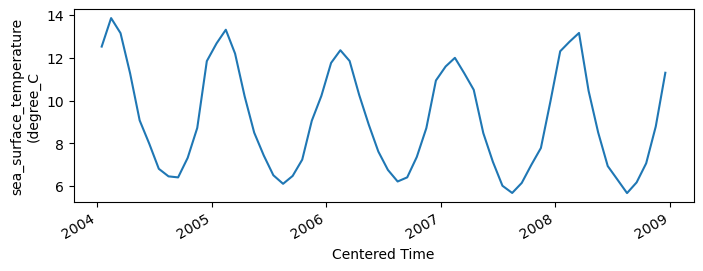

In [22]:
da = subset_ds.sstMasked

geopromedio_ecoregion_ds.plot(figsize=(8,2.5))
plt.ylabel(f"{da.standard_name}\n({da.units}")
plt.title(None)

plt.savefig(f"serietemporal-{ecoregion_seleccion_limpio}.png")
plt.show();

### Convertir a DataFrame y exportar a csv

Primero "limpiamos" el DataFrame para quitar columna innecesaria, cambiar nombres de columnas, y dejar sólo fechas para el índice.

In [23]:
geopromedio_ecoregion_df = (
    geopromedio_ecoregion_ds.to_dataframe()
    .drop(columns='spatial_ref')
    .rename(columns={'sstMasked':'SST_oC'})
)
geopromedio_ecoregion_df.index = geopromedio_ecoregion_df.index.date
geopromedio_ecoregion_df.index.name = 'fecha'

len(geopromedio_ecoregion_df)

60

In [24]:
geopromedio_ecoregion_df.head()

,SST_oC
fecha,
2004-01-16,12.530292
2004-02-15,13.863257
2004-03-16,13.159034
2004-04-15,11.280445
2004-05-16,9.076468


In [25]:
nombre_archivo_csv = f"sst_mensual_{ecoregion_seleccion_limpio}.csv"
geopromedio_ecoregion_df.to_csv(nombre_archivo_csv)

nombre_archivo_csv

'sst_mensual_Patagonian-Shelf.csv'